<h1 style="text-align:center;">Exploratory Data Analyis</h1>

At the core of every recommender-system setup is the user-item matrix or interaction matrix. The idea is that a user 'interacts' with an item (can be a product or piece of content). This interaction is often measured in the form of a five star review. In most datasets, the number of non-interacted items << the number of interactions. This results in very sparse datasets. The goal of the recommender system is to recommend a slate of items to a given user that he/she has not seen.
In this exploratory data analysis (EDA) we explore two well-known datasets 1) MovieLens 1M, 2) Goodreads Bookreviews.

Since we will focus on the interaction matrix for training and evaluating, we will ignore the secondary features for now.

In [1]:
from IPython.display import HTML
hide_code_script = """
<script>
$(document).ready(function(){
    // Hide code cells
    $('div.input').hide();
    
    // Variable to track code visibility
    window.code_shown = false;
    
    // Function to toggle code cells
    window.code_toggle = function() {
        if (window.code_shown) {
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        window.code_shown = !window.code_shown;
    }
    
    // Add toggle button
    if ($('.toggle-button').length === 0) {
        var toggle_button = $('<button/>')
                            .text('Toggle code')
                            .click(window.code_toggle)
                            .addClass('toggle-button');
        $('.output').first().prepend(toggle_button);
    }
});
</script>
"""

# Display the toggle button and hide the code cells
display(HTML(hide_code_script))

# Export button
display(HTML("<form action='javascript:print()'><input type='submit' value='Export to PDF'></form>"))

In [2]:

# Display the toggle button and hide the code cells
display(HTML(hide_code_script))


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm import trange
from IPython.display import HTML, display

<h1 style="text-align:center;">MovieLens-1M</h1>

In [4]:
# Load the MovieLens dataset
ratings = pd.read_csv(f'./data/ml-1m/ratings.dat',
                         delimiter='::', engine='python', header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])
movies = pd.read_csv(f'./data/ml-1m/movies.dat',
                        delimiter='::', engine= 'python', header=None, encoding='latin-1',
                      names=['movie_name', 'genre'])

print(f"The dataset contains {len(ratings)} historical ratings of {len(ratings['movie_id'].unique())} movies by {len(ratings['user_id'].unique())} unique users. This is a 20-core dataset, meaning that there are no users that have rated fewer than 20 movies. ")
print(ratings.groupby('user_id').count().min())


The dataset contains 1000209 historical ratings of 3706 movies by 6040 unique users. This is a 20-core dataset, meaning that there are no users that have rated fewer than 20 movies. 
movie_id    20
rating      20
time        20
dtype: int64


In [5]:
print("This is what the interaction dataframe looks like. It contains a user_id, a movie_id, a rating between 1 and 5,as well as a timestamp at which the rating was given. There are other features available (such as genre or demographic data) but will not likely be used for this thesis.")

# Assuming you already have 'ratings' DataFrame
head = ratings.head()

# Convert DataFrame to HTML table
html_table = head.to_html()

# Wrap the HTML table in a div with centered styling
centered_table_html = f"<div style='display: flex; justify-content: center;'>{html_table}</div>"

# Display the centered HTML table
display(HTML(centered_table_html))

This is what the interaction dataframe looks like. It contains a user_id, a movie_id, a rating between 1 and 5,as well as a timestamp at which the rating was given. There are other features available (such as genre or demographic data) but will not likely be used for this thesis.


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
print("Since the integer-values for movie and user are identifiers, it is not interesting or meaningful to report on their descriptive statistics. It is however for the ratings themselves.")


# Assuming you already have 'ratings' DataFrame
describe = ratings.describe()[['rating']]

# Convert DataFrame to HTML table
html_table_2 = describe.to_html()

# Wrap the HTML table in a div with centered styling
centered_table_html_2 = f"<div style='display: flex; justify-content: center;'>{html_table_2}</div>"

# Display the centered HTML table
display(HTML(centered_table_html_2))

Since the integer-values for movie and user are identifiers, it is not interesting or meaningful to report on their descriptive statistics. It is however for the ratings themselves.


,rating
count,1.000209e+06
mean,3.581564e+00
std,1.117102e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [7]:
print("In the following graph, you can see the distribution over the number of ratings per user. Note that the functional relationship between users and number of ratings per user is a power-law.")

# Assuming you already have 'ratings' DataFrame
user_rating_counts = ratings.groupby('user_id')['rating'].count().reset_index()

# Plotting
plt.figure(figsize=(10, 4));
sns.histplot(user_rating_counts['rating'], bins=30, kde=True);
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('user_count_plot.png');
plt.clf();
plt.close()  # Close the figure to suppress the print


# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='user_count_plot.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html));

In the following graph, you can see the distribution over the number of ratings per user. Note that the functional relationship between users and number of ratings per user is a power-law.


In [8]:
print("Likewise, the number of ratings per movie is distributed in a similar fashion.")

# Assuming you already have 'ratings' DataFrame
item_rating_counts = ratings.groupby('movie_id')['rating'].count().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(item_rating_counts['rating'], bins=30, kde=True)
plt.title('Number of Ratings per Item')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('item_count_plot.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='item_count_plot.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

Likewise, the number of ratings per movie is distributed in a similar fashion.


When plotting the user-item-matrix as a heatmap where temperature equals the relevance of a movie for a user, you can see that the dataset is rather sparse. Meaning that every pixel that isn't coloured does not have a rating. Another thing to note is the grid-formation that again underpins our findings of the previous two plots.


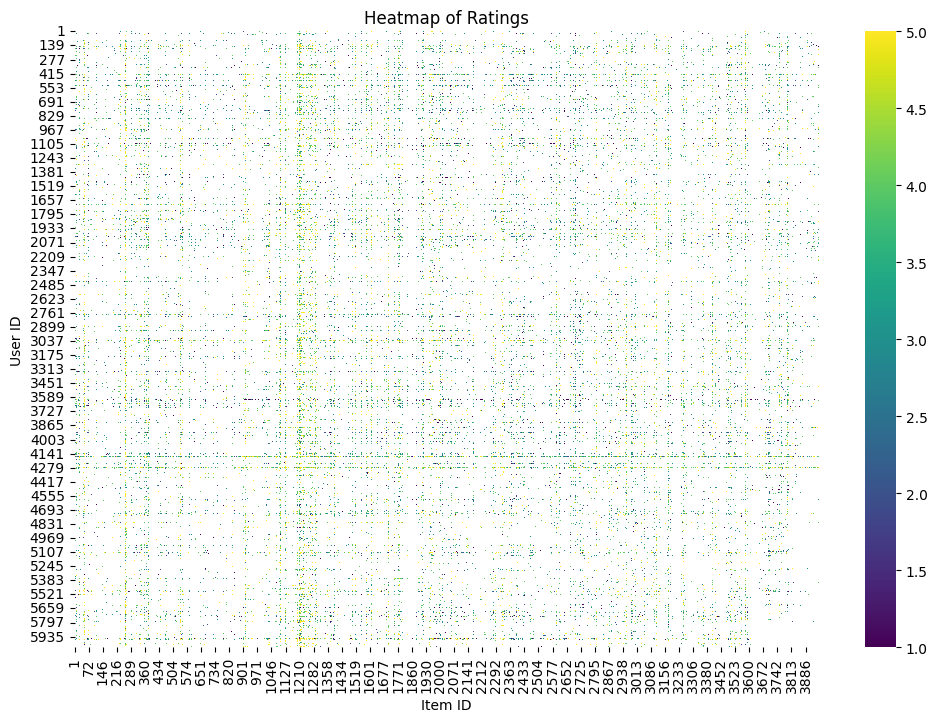

In [9]:
print("When plotting the user-item-matrix as a heatmap where temperature equals the relevance of a movie for a user, you can see that the dataset is rather sparse. Meaning that every pixel that isn't coloured does not have a rating. Another thing to note is the grid-formation that again underpins our findings of the previous two plots.")

# Heatmap of ratings
rating_matrix = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')
plt.figure(figsize=(12, 8))
sns.heatmap(rating_matrix, cmap='viridis', cbar=True)
plt.title('Heatmap of Ratings')
plt.xlabel('Item ID')
plt.ylabel('User ID')
plt.show()

In [10]:
print("The average ratings received per movie appear to be more normally distributed, with a slight skew.")

# Assuming you already have 'ratings' DataFrame
item_avg_rating = ratings.groupby('movie_id')['rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(item_avg_rating['rating'], bins=30, kde=True)
plt.title('Average Rating Distribution per Item')
plt.xlabel('Average Rating')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('item_mean_plot.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='item_mean_plot.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

The average ratings received per movie appear to be more normally distributed, with a slight skew.


In [11]:
print("The average rating per user appears to be a skewed normal distribution. The mean is skwed to the right, meaning that users tend to give an above average rating when they do rate a movie.")

# Assuming you already have 'data' DataFrame
user_avg_rating = ratings.groupby('user_id')['rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(user_avg_rating['rating'], bins=30, kde=True)
plt.title('Average Rating Distribution per User')
plt.xlabel('Average Rating')
plt.ylabel('Count')

# Save the plot with the specified filename
plt.savefig('user_mean_plot.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='user_mean_plot.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

The average rating per user appears to be a skewed normal distribution. The mean is skwed to the right, meaning that users tend to give an above average rating when they do rate a movie.


In [12]:
print("The following plots show the ratings over time. The first plot clearly shows that (almost) all ratings have occured in 2000. Then there are almost no new ratings. This is potentially caused by the dataset being a subset of a larger corpus. The second plot also shows the average rating given by users go down over time, yet it stays around 3.5 on average.")
# Assuming you already have 'ratings' DataFrame

# Convert the timestamp to datetime using January 1, 1970 as the start of the epoch
ratings['time'] = pd.to_datetime(ratings['time'], unit='s', origin='unix')

# Extract year and month from the timestamp
ratings['year'] = ratings['time'].dt.year
ratings['month'] = ratings['time'].dt.month

# Plotting number of ratings over time
plt.figure(figsize=(10, 4))
ratings_over_time = ratings.groupby([ratings['time'].dt.year, ratings['time'].dt.month]).size()
ratings_over_time.plot(marker='o')
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot to a temporary file and clear the current plot
plt.savefig('ratings_over_time.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='ratings_over_time.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

# Plotting average rating over time
plt.figure(figsize=(10, 4))
average_rating_over_time = ratings.groupby([ratings['time'].dt.year, ratings['time'].dt.month])['rating'].mean()
average_rating_over_time.plot(marker='o', color='orange')
plt.title('Average Rating Over Time')
plt.xlabel('Time')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the plot to a temporary file and clear the current plot
plt.savefig('average_rating_over_time.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='average_rating_over_time.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

The following plots show the ratings over time. The first plot clearly shows that (almost) all ratings have occured in 2000. Then there are almost no new ratings. This is potentially caused by the dataset being a subset of a larger corpus. The second plot also shows the average rating given by users go down over time, yet it stays around 3.5 on average.


<h1 style="text-align:center;">Goodreads Book Reviews</h1>

In [13]:
df_reads = pd.read_csv("./data/goodreads.txt", sep='\t', header=None)
df_reads = df_reads.rename(columns={0: 'user', 1: 'item', 2: 'rating'})

print(f"The dataset contains {len(df_reads)} book reviews (rating) of {len(df_reads['item'].unique())} books by {len(df_reads['user'].unique())} unique users. This is a  10-core dataset, which means that the data has been made less sparse by removing all users that have interacted with fewer than 10 items. ")
print("This can be checked as follows:")
df_reads.groupby('user').count().min()

The dataset contains 137045 book reviews (rating) of 3423 books by 2225 unique users. This is a  10-core dataset, which means that the data has been made less sparse by removing all users that have interacted with fewer than 10 items. 
This can be checked as follows:


item      10
rating    10
dtype: int64

In [14]:
print("This is what the interaction dataframe looks like. It contains a user, an item as well as a rating between 1 and 5. Just like the MovieLens dataset, there are more features, but these are likely not going to be used in this thesis.")

# Assuming you already have 'ratings' DataFrame
head = df_reads.head()

# Convert DataFrame to HTML table
html_table = head.to_html()

# Wrap the HTML table in a div with centered styling
centered_table_html = f"<div style='display: flex; justify-content: center;'>{html_table}</div>"

# Display the centered HTML table
display(HTML(centered_table_html))

This is what the interaction dataframe looks like. It contains a user, an item as well as a rating between 1 and 5. Just like the MovieLens dataset, there are more features, but these are likely not going to be used in this thesis.


,user,item,rating
0,1,8695,5
1,1,4197,5
2,1,2767052,5
3,1,59715,5
4,1,119073,3


In [15]:
print("Since the integer-values for item (book) and user are identifiers, it is not interesting or meaningful to report on their descriptive statistics. It is, however, for the ratings themselves.")


# Assuming you already have 'ratings' DataFrame
describe = df_reads.describe()[['rating']]

# Convert DataFrame to HTML table
html_table_2 = describe.to_html()

# Wrap the HTML table in a div with centered styling
centered_table_html_2 = f"<div style='display: flex; justify-content: center;'>{html_table_2}</div>"

# Display the centered HTML table
display(HTML(centered_table_html_2))

Since the integer-values for item (book) and user are identifiers, it is not interesting or meaningful to report on their descriptive statistics. It is, however, for the ratings themselves.


,rating
count,137045.000000
mean,3.834164
std,0.989053
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [16]:
print("Again, we can see the distribution over the number of ratings per user follows a power-law distribution.")

# Assuming you already have 'ratings' DataFrame
user_rating_counts = df_reads.groupby('user')['rating'].count().reset_index()

# Plotting
plt.figure(figsize=(10, 4));
sns.histplot(user_rating_counts['rating'], bins=30, kde=True);
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('user_count_plot_r.png');
plt.clf();
plt.close()  # Close the figure to suppress the print


# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='user_count_plot_r.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html));

Again, we can see the distribution over the number of ratings per user follows a power-law distribution.


In [17]:
print("Likewise, the number of ratings per book is distributed in a similar fashion, but this time with a much thinner and longer long-tail.")

# Assuming you already have 'ratings' DataFrame
item_rating_counts = df_reads.groupby('item')['rating'].count().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(item_rating_counts['rating'], bins=30, kde=True)
plt.title('Number of Ratings per Item')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('item_count_plot_r.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='item_count_plot_r.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

Likewise, the number of ratings per book is distributed in a similar fashion, but this time with a much thinner and longer long-tail.


When plotting the user-item-matrix as a heatmap where temperature equals the relevance of a movie for a user, you can see that the dataset is rather sparse. Meaning that every pixel that isn't coloured does not have a rating. Another thing to note is the slight grid-formation that again underpins our findings of the previous two plots. Note also, that this dataset is much sparser than the MovieLens 1M dataset.


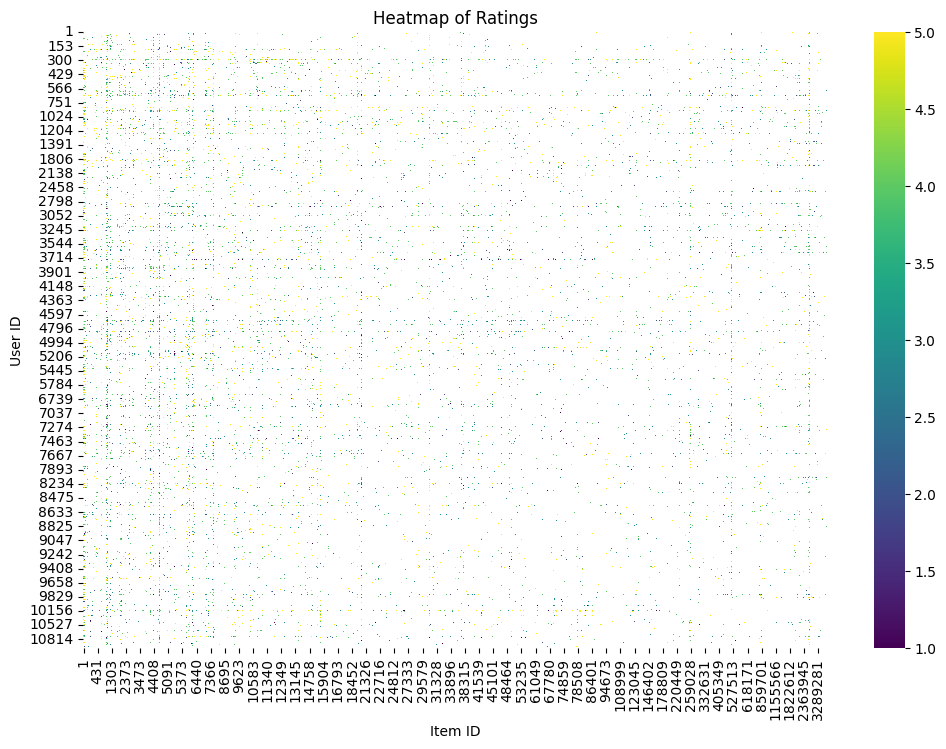

In [18]:
print("When plotting the user-item-matrix as a heatmap where temperature equals the relevance of a movie for a user, you can see that the dataset is rather sparse. Meaning that every pixel that isn't coloured does not have a rating. Another thing to note is the slight grid-formation that again underpins our findings of the previous two plots. Note also, that this dataset is much sparser than the MovieLens 1M dataset.")

# Heatmap of ratings
rating_matrix = df_reads.pivot_table(index='user', columns='item', values='rating')
plt.figure(figsize=(12, 8))
sns.heatmap(rating_matrix, cmap='viridis', cbar=True)
plt.title('Heatmap of Ratings')
plt.xlabel('Item ID')
plt.ylabel('User ID')
plt.show()

In [19]:
print("The average ratings received per movie appear to be more normally distributed.")

# Assuming you already have 'ratings' DataFrame
item_avg_rating = df_reads.groupby('item')['rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(item_avg_rating['rating'], bins=30, kde=True)
plt.title('Average Rating Distribution per Item')
plt.xlabel('Average Rating')
plt.ylabel('Count')

# Save the plot to a temporary file and clear the current plot
plt.savefig('item_mean_plot_r.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='item_mean_plot_r.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

The average ratings received per movie appear to be more normally distributed.


In [20]:
print("The average rating per user appears to be a standard normal distribution. The mean is positioned somewhat to the right of the rating scale, meaning that users tend to give an above average rating when they do rate a movie.")

# Assuming you already have 'data' DataFrame
user_avg_rating = df_reads.groupby('user')['rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(user_avg_rating['rating'], bins=30, kde=True)
plt.title('Average Rating Distribution per User')
plt.xlabel('Average Rating')
plt.ylabel('Count')

# Save the plot with the specified filename
plt.savefig('user_mean_plot_r.png')
plt.clf()
plt.close()  # Close the figure to suppress the print

# Convert the plot to HTML
centered_plot_html = f"<div style='display: flex; justify-content: center;'><img src='user_mean_plot_r.png'></div>"

# Display the centered plot
display(HTML(centered_plot_html))

The average rating per user appears to be a standard normal distribution. The mean is positioned somewhat to the right of the rating scale, meaning that users tend to give an above average rating when they do rate a movie.


In [21]:
# df_reads.describe()

In [22]:
# df_yelp = pd.read_csv("./data/yelp.txt", sep='\t', header=None)
# df_yelp = df_yelp.rename(columns={0: 'user', 1: 'item', 2: 'rating'})

# df_yelp.head(), df_yelp.describe()

In [23]:
# df_google = pd.read_csv("./data/google_reviews.txt", sep='\t', header=None)
# df_google = df_google.rename(columns={0: 'user', 1: 'item', 2: 'rating'})

# df_google.head(), df_google.describe()

In [24]:
# df_google = pd.read_csv("./data/google_reviews.txt", sep='\t', header=None)
# df_google = df_google.rename(columns={0: 'user', 1: 'item', 2: 'rating'})

In [25]:
# # Summary statistics of the ratings
# print("\nSummary Statistics of Ratings:")
# data['rating'].describe()